In [1]:
import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import pickle
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer

C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:33: DeprecationWarning: invalid escape sequence \d
  """


In [16]:
import os, sys

In [17]:
from gensim.models.wrappers import LdaMallet

In [40]:
stop_words.extend(['interview', 'weather', 'abc', 'australia', 'australian','queensland', 'australias','sydney', 'nz'])

In [20]:
data = pd.read_csv('abcnews-date-text.csv', error_bad_lines =False)
data['publish_date'] = pd.to_datetime(data['publish_date'].astype(str), format = '%Y%m%d')

In [21]:
data['publish_date'] = pd.DatetimeIndex(data['publish_date']).year

In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data['headline_text']))

In [37]:
data_words[:10]

[['aba', 'decides', 'against', 'community', 'broadcasting', 'licence'],
 ['act', 'fire', 'witnesses', 'must', 'be', 'aware', 'of', 'defamation'],
 ['calls', 'for', 'infrastructure', 'protection', 'summit'],
 ['air', 'nz', 'staff', 'in', 'aust', 'strike', 'for', 'pay', 'rise'],
 ['air', 'nz', 'strike', 'to', 'affect', 'australian', 'travellers'],
 ['ambitious', 'olsson', 'wins', 'triple', 'jump'],
 ['antic', 'delighted', 'with', 'record', 'breaking', 'barca'],
 ['aussie', 'qualifier', 'stosur', 'wastes', 'four', 'memphis', 'match'],
 ['aust', 'addresses', 'un', 'security', 'council', 'over', 'iraq'],
 ['australia', 'is', 'locked', 'into', 'war', 'timetable', 'opp']]

In [23]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [24]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
data_words_nostops = pd.Series(data_words_nostops)
data_lemmatized = data_words_nostops.apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='v') for word in x])

In [25]:
with open('data_lemmatized.pickle', 'wb') as f:
    pickle.dump(data_lemmatized, f, pickle.HIGHEST_PROTOCOL)

In [2]:
with open('data_lemmatized.pickle', 'rb') as f:
    data_lemmatized = pickle.load(f)

In [26]:
temp = data
temp['lemmatize'] = data_lemmatized
for i in range(15):
    globals()['trend{}'.format(i+2003)] = temp.loc[temp.publish_date == i+2003]

In [27]:
trend_list = [trend2003, trend2004, trend2005, trend2006, trend2007, trend2008, trend2009, trend2010, trend2011, trend2012, trend2013, trend2014, trend2015, trend2016, trend2017]

In [38]:
lemmatized = list(trend2003['lemmatize'])
id2word = corpora.Dictionary(lemmatized)

In [41]:
id2word.filter_extremes(no_below=5, no_above=0.3, keep_n=10000)

In [42]:
texts = lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [45]:
passes=10
coherencesT=[]
perplexitiesT=[]
warnings.filterwarnings('ignore')
for i in range(10):
    if i==0:
        ntopics = 2
    else:
        ntopics = 5*(i+1)
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=ntopics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10000,
                                           passes=passes,
                                           alpha='auto',
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print("Coherence",coherence_lda)
    coherencesT.append(coherence_lda)
    print('Perplexity: ', lda_model.log_perplexity(corpus),'\n\n')
    perplexitiesT.append(lda_model.log_perplexity(corpus))

Coherence 0.4010277779250845
Perplexity:  -7.838817046364008 


Coherence 0.31795043269595435
Perplexity:  -7.978211041046232 


Coherence 0.3647100519096436
Perplexity:  -8.591614785085016 


Coherence 0.3980348101834011
Perplexity:  -8.826584852495166 


Coherence 0.4183155417852907
Perplexity:  -9.05789233193494 


Coherence 0.45977877702305625
Perplexity:  -9.27415496972899 


Coherence 0.4907582366916047
Perplexity:  -9.544500586120208 


Coherence 0.5120799524608235
Perplexity:  -9.768117837660533 


Coherence 0.5212644771149042
Perplexity:  -10.050515709891611 


Coherence 0.5490208988706065
Perplexity:  -10.399639104981343 




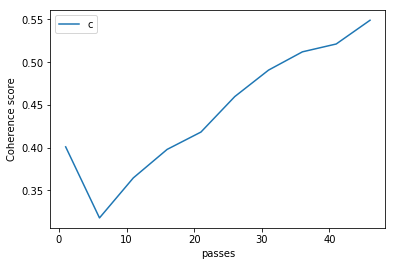

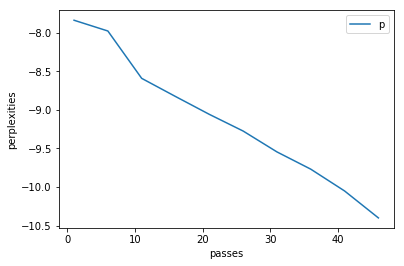

In [48]:
# Show graph
limit=50; start=1; step=5;
x = range(start, limit, step)
plt.plot(x, coherencesT)
plt.xlabel("passes")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


# Show graph
limit=50; start=1; step=5;
x = range(start, limit, step)
plt.plot(x, perplexitiesT)
plt.xlabel("passes")
plt.ylabel("perplexities")
plt.legend(("perplexities_values"), loc='best')
plt.show()

In [49]:
# Build LDA model
optimized_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=50, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [50]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.39965607451244

Coherence Score:  0.5490208988706065


In [51]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.065*"british" + 0.062*"fail" + 0.059*"sentence" + 0.047*"perth" + '
  '0.044*"despite" + 0.037*"speed" + 0.034*"chase" + 0.032*"southern" + '
  '0.031*"sell" + 0.029*"western"'),
 (17,
  '0.042*"star" + 0.041*"reform" + 0.037*"fin" + 0.029*"alert" + '
  '0.029*"senate" + 0.029*"impact" + 0.025*"another" + 0.025*"benefit" + '
  '0.024*"olympic" + 0.022*"internet"'),
 (49,
  '0.110*"vic" + 0.074*"hop" + 0.061*"rail" + 0.032*"policy" + 0.028*"east" + '
  '0.028*"await" + 0.024*"tv" + 0.024*"nats" + 0.024*"afghan" + '
  '0.020*"russia"'),
 (24,
  '0.095*"road" + 0.067*"mine" + 0.065*"safety" + 0.060*"study" + '
  '0.057*"prepare" + 0.036*"flood" + 0.032*"promise" + 0.032*"men" + '
  '0.029*"detention" + 0.026*"conference"'),
 (18,
  '0.097*"case" + 0.095*"pay" + 0.048*"save" + 0.042*"double" + 0.039*"scheme" '
  '+ 0.029*"right" + 0.029*"export" + 0.026*"behind" + 0.024*"alcohol" + '
  '0.023*"officials"'),
 (22,
  '0.072*"give" + 0.051*"coach" + 0.043*"nauru" + 0.042*"order" + 0

In [52]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.115766  0.027121       1        1  3.739251
25     0.156519 -0.055748       2        1  3.428702
39    -0.254833 -0.137325       3        1  2.707592
27     0.052717  0.061924       4        1  2.681504
3     -0.028071 -0.139523       5        1  2.500098
45    -0.085892 -0.118110       6        1  2.388762
14     0.011828  0.110002       7        1  2.375264
40    -0.192415 -0.046782       8        1  2.317536
35     0.146929 -0.054139       9        1  2.257021
6     -0.084156  0.013817      10        1  2.236664
31    -0.051343 -0.012480      11        1  2.205916
4      0.060638  0.036500      12        1  2.149373
42    -0.042339  0.102026      13        1  2.127758
15     0.038148 -0.053603      14        1  2.118574
5      0.062320 -0.085070      15        1  2.052443
41    -0.126108 -0.082494      16        1  2.035393
16     0.050403  0.046276      17        1  2.032219
33    -0.007682  0.059776      18        1  2.018481
43    -0.202438 -0.137386      19        1  1.993556
46     0.064875 -0.033531      20        1  1.965489
8      0.000806  0.035874      21        1  1.947464
23     0.122423 -0.076537      22        1  1.939609
9      0.086336  0.002910      23        1  1.935306
47     0.001112  0.110301      24        1  1.922000
36     0.007635 -0.006492      25        1  1.899236
20     0.089924 -0.083565      26        1  1.893690
7     -0.054865  0.104465      27        1  1.887907
38     0.026294  0.049892      28        1  1.883998
26     0.118866 -0.017422      29        1  1.876106
37    -0.007617 -0.027374      30        1  1.873281
29     0.036573  0.014082      31        1  1.852128
21     0.064305 -0.090453      32        1  1.843355
19    -0.002583  0.069795      33        1  1.839896
30     0.098632 -0.053126      34        1  1.838909
44     0.074938  0.021558      35        1  1.837361
1     -0.049858  0.028751      36        1  1.820307
12    -0.043190  0.137611      37        1  1.735732
10     0.020630  0.079560      38        1  1.693802
11     0.001533 -0.006278      39        1  1.689872
32     0.054659  0.043753      40        1  1.687847
48    -0.044210  0.043850      41        1  1.675759
34    -0.060149  0.116190      42        1  1.652192
13    -0.003806  0.070461      43        1  1.629761
18     0.036244  0.002844      44        1  1.610431
28     0.081132 -0.123318      45        1  1.609765
22    -0.040771  0.159739      46        1  1.587432
24     0.052692 -0.140245      47        1  1.578340
49    -0.021200 -0.006835      48        1  1.570864
17    -0.054448  0.094253      49        1  1.517271
0     -0.045370 -0.055497      50        1  1.338786, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
640   Default  2561.000000          us  2561.000000  30.0000  30.0000
175   Default  1790.000000        govt  1790.000000  29.0000  29.0000
293   Default  1633.000000         man  1633.000000  28.0000  28.0000
454   Default  1109.000000        face  1109.000000  27.0000  27.0000
229   Default  1216.000000       court  1216.000000  26.0000  26.0000
343   Default  1093.000000      charge  1093.000000  25.0000  25.0000
395   Default  1013.000000       claim  1013.000000  24.0000  24.0000
576   Default  1309.000000        kill  1309.000000  23.0000  23.0000
40    Default  1094.000000        iraq  1094.000000  22.0000  22.0000
8     Default   928.000000        fire   928.000000  21.0000  21.0000
368   Default   881.000000        warn   881.000000  20.0000  20.0000
39    Default  1426.000000     council  1426.000000  19.0000  19.0000
291   Default   799.000000        find   799.000000  18.0000  18.0000
105   Default   901.000000        fund   901.000000  17.0000  17.0000
319   Default   761.000000    consider   761.000000  16.0000  16.0000
659   Defau

In [36]:
os.environ['MALLET_HOME'] = 'C:/Users/JSW/Desktop/4-1/NLP/mallet-2.0.8/mallet-2.0.8'

In [38]:
mallet_path = 'C:/Users/JSW/Desktop/4-1/NLP/mallet-2.0.8/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [39]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('warn', 0.015987282843192913),
   ('mine', 0.015464971045759055),
   ('water', 0.014465765868059498),
   ('hunter', 0.014420347450891336),
   ('china', 0.014420347450891336),
   ('plan', 0.013489269898944022),
   ('farm', 0.013035085727262405),
   ('deal', 0.011468150334960826),
   ('industry', 0.00967412285681844),
   ('power', 0.008674917679118883)]),
 (1,
  [('australian', 0.03381177366264359),
   ('fire', 0.025392418101614456),
   ('market', 0.01974965852347791),
   ('house', 0.015808683580017465),
   ('price', 0.013188830918739784),
   ('lead', 0.012606641438455855),
   ('rise', 0.01231554669831389),
   ('share', 0.012136411473611141),
   ('record', 0.011867708636557022),
   ('hill', 0.011621397702590743)]),
 (2,
  [('country', 0.035840228639915185),
   ('nsw', 0.03549450296171664),
   ('wa', 0.03385806808491023),
   ('rural', 0.031875907529905274),
   ('hour', 0.03162237536589301),
   ('sa', 0.024615668287735957),
   ('qld', 0.021273653398483416),
   ('nt', 0.01636434876

In [40]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [42]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

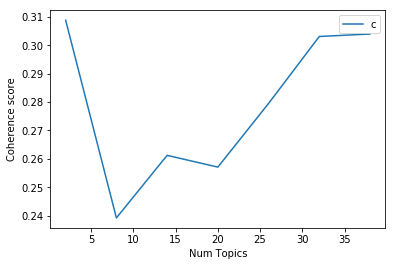

In [43]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()